# 学习特征表示
为了表征足够复杂的输入，特征本身应该分级表示。持这一想法的研究者相信，多层神经网络可能可以学得数据的多级表征，并逐级表示越来越抽象的概念或模式。以图像分类为例，并回忆5.1节（二维卷积层）中物体边缘检测的例子。在多层神经网络中，图像的第一级的表示可以是在特定的位置和⻆度是否出现边缘；而第二级的表示说不定能够将这些边缘组合出有趣的模式，如花纹；在第三级的表示中，也许上一级的花纹能进一步汇合成对应物体特定部位的模式。这样逐级表示下去，最终，模型能够较容易根据最后一级的表示完成分类任务。需要强调的是，输入的逐级表示由多层模型中的参数决定，而这些参数都是学出来的。

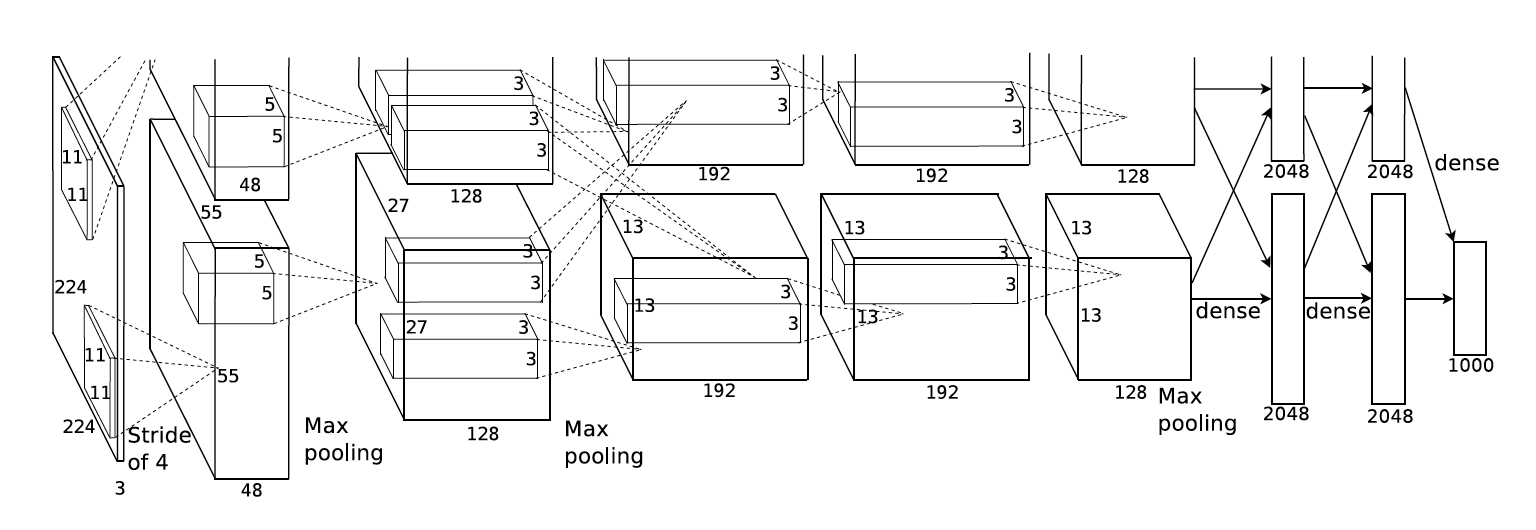

In [1]:
import time
import torch
from torch import nn, optim
import torchvision
import sys
sys.path.append("../深度学习基础/") 
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, 11, 4),  # in_channels, out_channels, kernel_size, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2),  # kernel_size, stride
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
            # 前两个卷积层后不使用池化层来减小输入的高和宽
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        # 这里全连接层的输出个数比LeNet中的大数倍。使用丢弃层来缓解过拟合
        self.fc = nn.Sequential(
            nn.Linear(256 * 5 * 5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
            nn.Linear(4096, 10),
        )
    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

打印看看网络结构

In [3]:
net = AlexNet()
print(net)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (

# 读取数据
虽然论文中`AlexNet`使用`ImageNet`数据集，但因为`ImageNet`数据集训练时间较长，我们仍用前面的`Fashion-MNIST`数据集来演示`AlexNet`。读取数据的时候我们额外做了一步将图像高和宽扩大到`AlexNet`使用的图像高和宽224。这个可以通过`torchvision.transforms.Resize`实例来实现。也就是说，我们在`ToTensor`实例前使用`Resize`实例，然后使用`Compose`实例来将这两个变换串联以方便调用。

In [4]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def load_data_fashion_mnist(batch_size, resize=None, root='~/Datasets/FashionMNIST'):
    """Download the fashion mnist dataset and then load into memory."""
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)
    
    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=4)
    
    return train_iter, test_iter

batch_size = 128
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)

# 训练
这时候我们可以开始训练`AlexNet`了。相对于`LeNet`，由于图片尺寸变大了而且模型变大了，所以需要更大的显存，也需要更长的训练时间了。

In [5]:
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cpu


KeyboardInterrupt: 

# 小结
+ AlexNet跟LeNet结构类似，但使用了更多的卷积层和更大的参数空间来拟合大规模数据集ImageNet。它是浅层神经网络和深度神经网络的分界线。
+ 虽然看上去AlexNet的实现比LeNet的实现也就多了几行代码而已，但这个观念上的转变和真正优秀实验结果的产生令学术界付出了很多年。